## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

## Note:
* 因計算時間過長，將EPOCHS從50降至20，隱藏層從三層[512, 256, 128]降至兩層[256, 128]。
* Batch_size越大，計算速度越快

## Additional Ref
* http://violin-tao.blogspot.com/2018/02/ml-batch-normalization.html

## 測試結果
* Batch size之準確度比較：128 > 256 > 32 > 16 > 2
* BN 放在Activation之前所造成的overfitting較放在Activation之後來的嚴重

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

## 1. 比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            
            
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95

In [7]:
results = {}

for bs in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.f" % (bs))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-BATCH_SIZEt-%s" % str(bs)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0804 15:34:14.566442 24724 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0804 15:34:14.568442 24724 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0804 15:34:14.590443 24724 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 15:34:14.591443 24724 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 15:34:14.594444 24724 depr

Experiment with BATCH_SIZE = 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 822,410
Trainable params: 821,642
Non-trainable params: 768
_____________________________________

W0804 15:34:14.788455 24724 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0804 15:34:14.940463 24724 deprecation.py:323] From E:\Users\moon\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 195s 4ms/step - loss: 2.2763 - acc: 0.1623 - val_loss: 2.3459 - val_acc: 0.2227
Epoch 2/20
50000/50000 [==============================] - 193s 4ms/step - loss: 2.2176 - acc: 0.1760 - val_loss: 2.2698 - val_acc: 0.2521
Epoch 3/20
50000/50000 [==============================] - 192s 4ms/step - loss: 2.2061 - acc: 0.1821 - val_loss: 2.3629 - val_acc: 0.2283
Epoch 4/20
50000/50000 [==============================] - 192s 4ms/step - loss: 2.2099 - acc: 0.1785 - val_loss: 2.3946 - val_acc: 0.2502
Epoch 5/20
50000/50000 [==============================] - 191s 4ms/step - loss: 2.2215 - acc: 0.1717 - val_loss: 2.4014 - val_acc: 0.2357
Epoch 6/20
50000/50000 [==============================] - 191s 4ms/step - loss: 2.2066 - acc: 0.1818 - val_loss: 2.2722 - val_acc: 0.2228
Epoch 7/20
50000/50000 [==============================] - 187s 4ms/step - loss: 2.2014 - acc: 0.1868 - val_loss: 2.3569 - 

50000/50000 [==============================] - 15s 292us/step - loss: 1.5619 - acc: 0.4487 - val_loss: 1.6244 - val_acc: 0.4201
Epoch 3/20
50000/50000 [==============================] - 15s 292us/step - loss: 1.4885 - acc: 0.4731 - val_loss: 1.5060 - val_acc: 0.4686
Epoch 4/20
50000/50000 [==============================] - 15s 292us/step - loss: 1.4480 - acc: 0.4888 - val_loss: 1.5441 - val_acc: 0.4454
Epoch 5/20
50000/50000 [==============================] - 15s 292us/step - loss: 1.4150 - acc: 0.4976 - val_loss: 1.5388 - val_acc: 0.4495
Epoch 6/20
50000/50000 [==============================] - 15s 292us/step - loss: 1.3833 - acc: 0.5118 - val_loss: 1.5397 - val_acc: 0.4524
Epoch 7/20
50000/50000 [==============================] - 15s 292us/step - loss: 1.3529 - acc: 0.5214 - val_loss: 1.4875 - val_acc: 0.4723
Epoch 8/20
50000/50000 [==============================] - 15s 293us/step - loss: 1.3378 - acc: 0.5256 - val_loss: 1.4678 - val_acc: 0.4827
Epoch 9/20
50000/50000 [==============

50000/50000 [==============================] - 5s 93us/step - loss: 1.5053 - acc: 0.4709 - val_loss: 1.5497 - val_acc: 0.4572
Epoch 4/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.4493 - acc: 0.4914 - val_loss: 1.5387 - val_acc: 0.4524
Epoch 5/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.4037 - acc: 0.5111 - val_loss: 1.4899 - val_acc: 0.4701
Epoch 6/20
50000/50000 [==============================] - 5s 93us/step - loss: 1.3646 - acc: 0.5225 - val_loss: 1.4898 - val_acc: 0.4753
Epoch 7/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.3313 - acc: 0.5351 - val_loss: 1.5804 - val_acc: 0.4501
Epoch 8/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.3018 - acc: 0.5449 - val_loss: 1.4676 - val_acc: 0.4841
Epoch 9/20
50000/50000 [==============================] - 5s 94us/step - loss: 1.2755 - acc: 0.5554 - val_loss: 1.4618 - val_acc: 0.4837
Epoch 10/20
50000/50000 [===========================

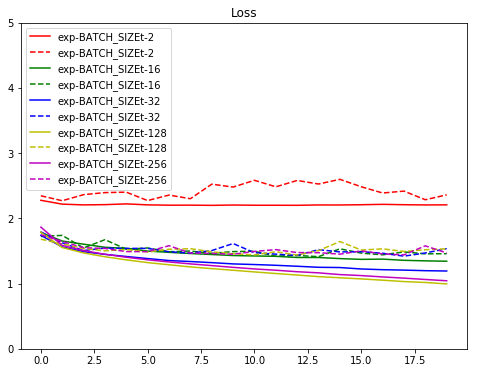

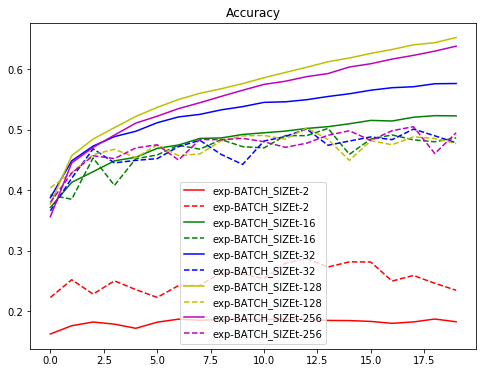

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 2. 嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [9]:
from keras.layers import Activation, BatchNormalization

def build_mlp2(input_shape, output_units=10, num_neurons=[256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
model = build_mlp2(input_shape=x_train.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
__________

In [13]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = [32,128]
MOMENTUM = 0.95

In [14]:
results = {}

for bs in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.f" % (bs))
    model = build_mlp2(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-BATCH_SIZEt-%s" % str(bs)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with BATCH_SIZE = 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)    

50000/50000 [==============================] - 6s 126us/step - loss: 0.7742 - acc: 0.7383 - val_loss: 1.6850 - val_acc: 0.46510.77
Epoch 19/20
50000/50000 [==============================] - 6s 129us/step - loss: 0.7476 - acc: 0.7464 - val_loss: 1.6834 - val_acc: 0.4635
Epoch 20/20
50000/50000 [==============================] - 6s 127us/step - loss: 0.7191 - acc: 0.7573 - val_loss: 1.9380 - val_acc: 0.4117


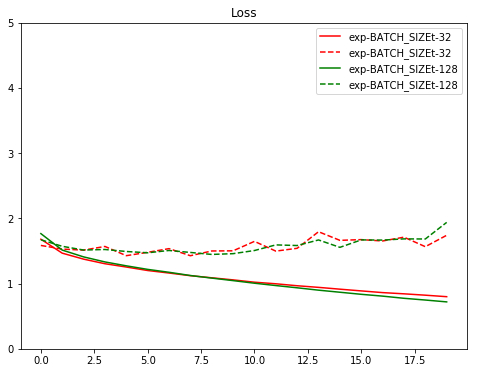

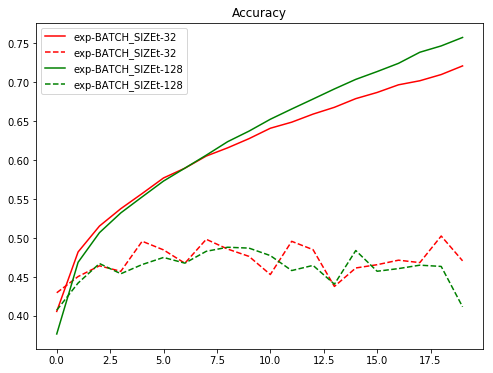

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 3. 將BN 放在 Input Layer 後，並比較結果

In [16]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp3(input_shape, output_units=10, num_neurons=[256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = [32,128]
MOMENTUM = 0.95

In [18]:
results = {}

for bs in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.f" % (bs))
    model = build_mlp2(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-BATCH_SIZEt-%s" % str(bs)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with BATCH_SIZE = 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)    

50000/50000 [==============================] - 7s 131us/step - loss: 0.7779 - acc: 0.7347 - val_loss: 2.0335 - val_acc: 0.3936
Epoch 19/20
50000/50000 [==============================] - 6s 128us/step - loss: 0.7514 - acc: 0.7463 - val_loss: 1.7054 - val_acc: 0.4726
Epoch 20/20
50000/50000 [==============================] - 6s 126us/step - loss: 0.7211 - acc: 0.7542 - val_loss: 1.9684 - val_acc: 0.4178


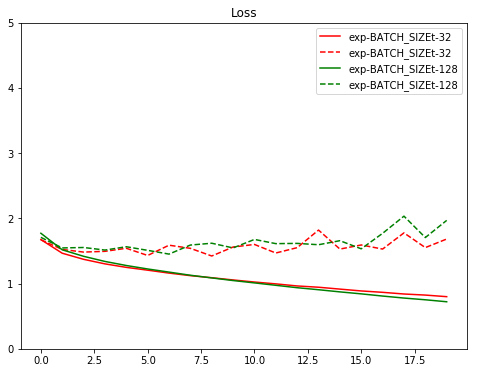

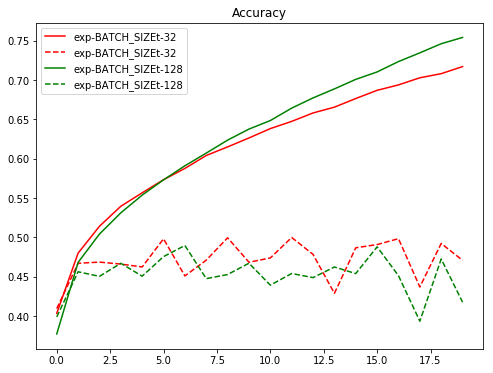

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()